In [1]:
# imports and stuff
from pyqg import qg_model, particles
import time
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# setup model
year = 24*60*60*360.
m =  qg_model.QGModel(tavestart=np.inf,
                      nx=128, dt=7200, tmax=4*year, ntd=2)
# spin up
m.run()

INFO:  Logger initialized
INFO: Step: 1000, Time: 7.20e+06, KE: 2.53e-07, CFL: 0.023
INFO: Step: 2000, Time: 1.44e+07, KE: 3.84e-07, CFL: 0.023
INFO: Step: 3000, Time: 2.16e+07, KE: 6.90e-07, CFL: 0.023
INFO: Step: 4000, Time: 2.88e+07, KE: 1.44e-06, CFL: 0.023
INFO: Step: 5000, Time: 3.60e+07, KE: 3.37e-06, CFL: 0.023
INFO: Step: 6000, Time: 4.32e+07, KE: 8.48e-06, CFL: 0.023
INFO: Step: 7000, Time: 5.04e+07, KE: 2.24e-05, CFL: 0.031
INFO: Step: 8000, Time: 5.76e+07, KE: 6.06e-05, CFL: 0.049
INFO: Step: 9000, Time: 6.48e+07, KE: 1.67e-04, CFL: 0.082
INFO: Step: 10000, Time: 7.20e+07, KE: 3.83e-04, CFL: 0.145
INFO: Step: 11000, Time: 7.92e+07, KE: 3.87e-04, CFL: 0.172
INFO: Step: 12000, Time: 8.64e+07, KE: 4.58e-04, CFL: 0.208
INFO: Step: 13000, Time: 9.36e+07, KE: 5.14e-04, CFL: 0.211
INFO: Step: 14000, Time: 1.01e+08, KE: 5.05e-04, CFL: 0.214
INFO: Step: 15000, Time: 1.08e+08, KE: 5.22e-04, CFL: 0.183
INFO: Step: 16000, Time: 1.15e+08, KE: 5.45e-04, CFL: 0.217
INFO: Step: 17000, Time

In [4]:
# set up lagrangian particles

dx = m.dx/4
dy = m.dy/4
x0,y0 = np.meshgrid( 
            np.arange(0,m.L,dx)+dx/2,
            np.arange(0,m.W,dy)+dy/2
)
pNy, pNx = x0.shape

x0 = x0.ravel()
y0 = y0.ravel()

Npart = x0.size
Npart

262144

In [70]:
# time to integrate
Ndays = 90
Tpart = 24*60*60*Ndays # 90 days
Tsave = 24*60*60 # daily

# number of particles to save
Nhold = Ndays

# let the model run some more by adding time to tmax
m.tmax = m.t + Tpart

n=-1

particle_history = np.zeros((Nhold,5,Npart))
lpa = particles.GriddedLagrangianParticleArray2D(x0, y0, m.nx, m.ny,
        periodic_in_x=True, periodic_in_y=True,
        xmin=0, xmax=m.L, ymin=0, ymax=m.W)


# set up extended grid for lagrangian particles
x = np.hstack([m.x[0,0]-m.dx, m.x[0,:], m.x[0,-1]+m.dx])
y = np.hstack([m.y[0,0]-m.dy, m.y[:,0], m.y[-1,0]+m.dy])

uprev = m.ufull[0].copy()
vprev = m.vfull[0].copy()
for snapshot in m.run_with_snapshots(
        tsnapstart=m.t, tsnapint=m.dt):

    # set up velocities for lagrangian advection
    u = m.ufull[0]
    v = m.vfull[0]
    
    lpa.step_forward_with_gridded_uv(
        uprev, vprev, u, v, m.dt)

    uprev = u.copy()
    vprev = v.copy()

    if n==-1:
        qi = m.q[0].copy()
        ui = u.copy()
        vi = v.copy()
        n+=1
        
    if (m.t % Tsave)==0:
        if (m.t * (Tsave*10))==0:
            print(m.t, n)
        # calculate relative vorticity manually
        # second order centered difference
        dudy = (np.roll(u,-1,axis=-2) - np.roll(u,1,axis=-2))/(2*m.dy)
        dvdx = (np.roll(v,-1,axis=-1) - np.roll(u,1,axis=-1))/(2*m.dx)
        vort = dvdx - dudy
        # vorticty on particles
        pvort = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, vort)
        
        # want to save the velocity *anomalies* so we don't have
        # to deal with mean flow effects in autocorrelation
        pu = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, m.u[0])
        pv = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, m.v[0])

        particle_history = np.roll(
            particle_history, 1, axis=0
        )
        particle_history[0,0] = lpa.x
        particle_history[0,1] = lpa.y
        particle_history[0,2] = pvort
        particle_history[0,3] = pu
        particle_history[0,4] = pv
        n+=1


INFO: Step: 19000, Time: 1.37e+08, KE: 5.48e-04, CFL: 0.211


### Remember that time goes backwards in particle history!

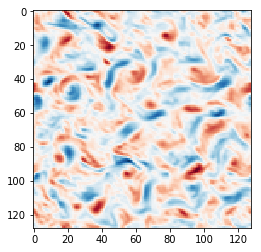

In [26]:
plt.imshow(vort, cmap='RdBu_r')

In [73]:
upart = particle_history[:,3]
vpart = particle_history[:,4]
# remove mean
upart -= upart.mean(axis=0)
vpart -= vpart.mean(axis=0)

vcorr = 0
ucorr = 0
for n in range(Npart):
    vcorr += np.correlate(vpart[:,n], vpart[:,n], mode='full')
    ucorr += np.correlate(upart[:,n], upart[:,n], mode='full')
vcorr /= Npart
ucorr /= Npart

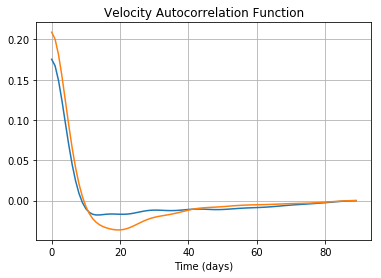

In [74]:
plt.plot(ucorr[Ndays-1:])
plt.plot(vcorr[Ndays-1:])
plt.xlabel('Time (days)')
plt.title('Velocity Autocorrelation Function')
plt.grid()


[]

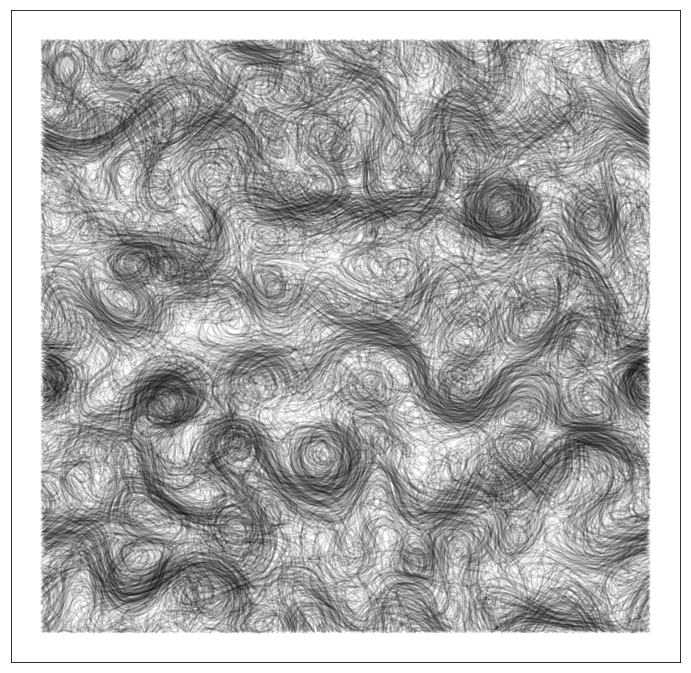

In [75]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(111)

nplot = 8
for j in range(0,pNy,nplot):
    for i in range(0,pNx,nplot):
        n = i + pNx*j
        # only plot trajectories that don't cross boundaries
        X = particle_history[:,0,n]
        Y = particle_history[:,1,n]
        lv = particle_history[:,2,n]
        dx = np.sqrt(np.diff(X)**2 + np.diff(Y)**2)
        jump_idx = np.where( dx >= (m.L/2))[0]+1
        for Xseg, Yseg, Zseg in zip(np.split(X, jump_idx),
                                    np.split(Y, jump_idx),
                                    np.split(lv, jump_idx)):
            plt.plot(Xseg, Yseg, 'k-', alpha=0.1)
            #plt.scatter(Xseg, Yseg, c=Zseg, alpha=0.1, s=3, edgecolor='none', cmap='RdBu_r')

ax.set_xticks([])
ax.set_yticks([])

In [76]:
lav_abs = np.abs(particle_history[:,2])
lav_abs.shape = (Nhold, pNy, pNx)

In [77]:
lav_abs.min()

1.446489175454483e-15

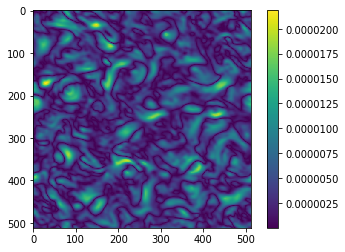

In [78]:
plt.imshow(lav_abs[-1])
plt.colorbar()

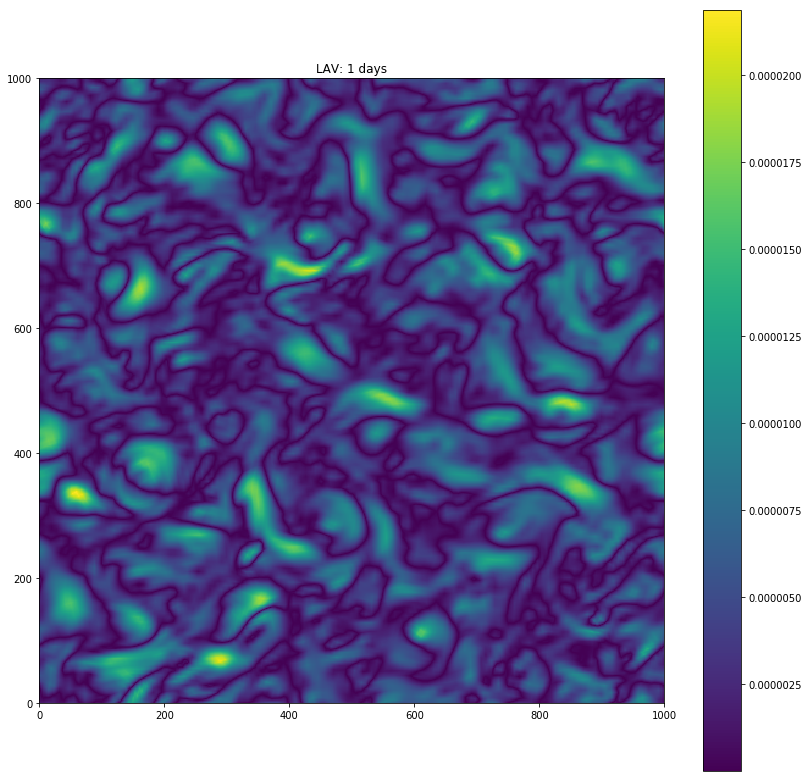

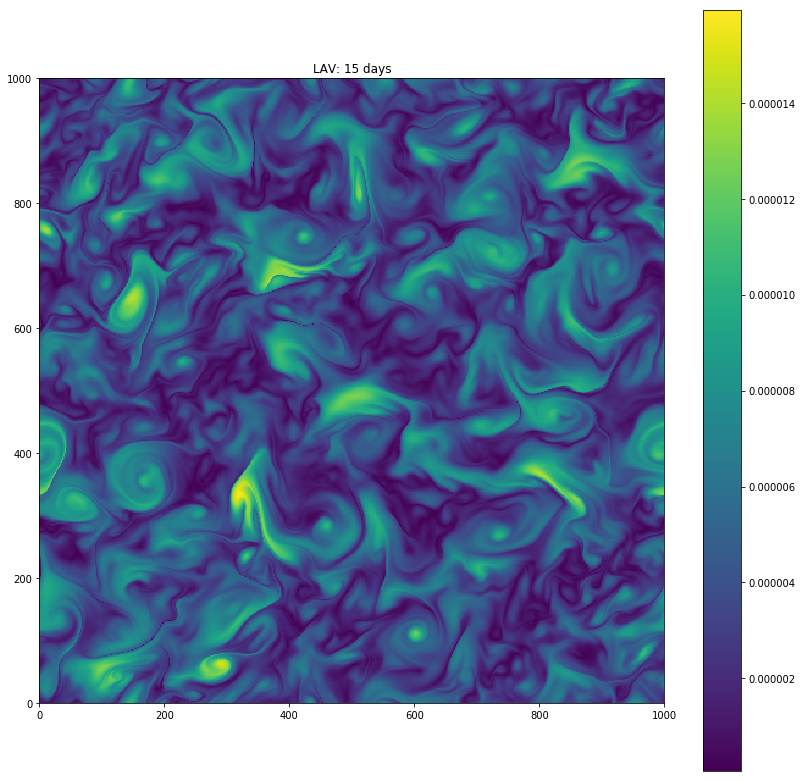

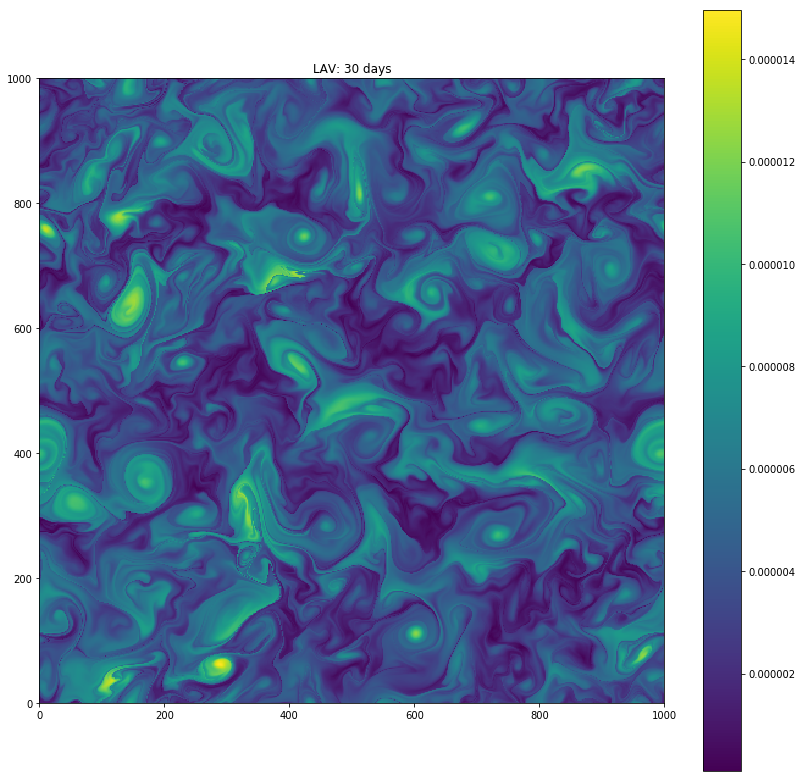

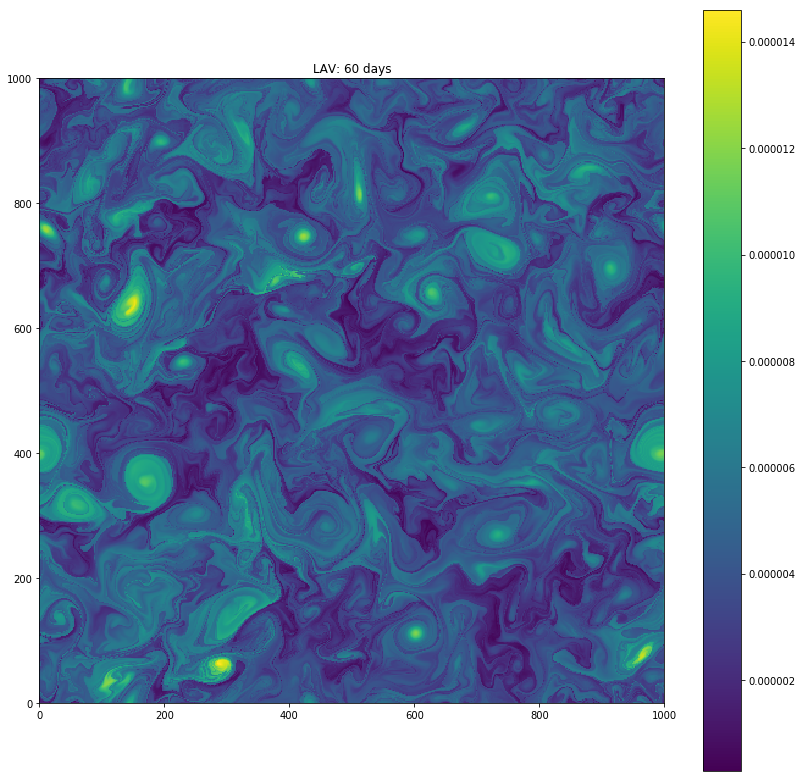

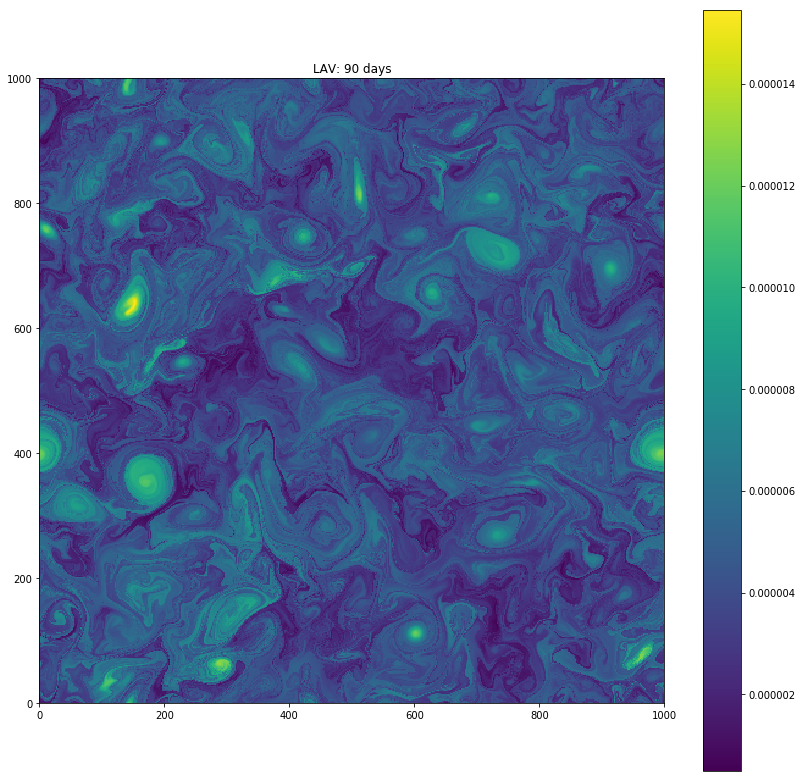

In [79]:
for ndays in [1, 15, 30, 60, 90]:

    lavd = lav_abs[-ndays:].mean(axis=0)
    
    plt.figure(figsize=(14,14))
    plt.imshow(lavd, extent=((0,m.L/1000,0,m.W/1000)), origin='bottom', cmap='viridis')
    #plt.clim([0,1.5e-5])
    plt.colorbar()
    plt.title('LAV: %g days' % ndays) 


In [80]:
from floater import rclv

In [81]:
kwargs = dict(convex_def=0.01, min_distance=10, step=3e-7,
              min_area=100., periodic=(True, True))
contours = list(rclv.find_convex_contours(lavd, **kwargs))

100%|██████████| 239/239 [00:01<00:00, 222.22it/s]


In [83]:
mask = rclv.label_points_in_contours(lavd.shape, [c[1] for c in contours])

In [85]:
len(contours)

3

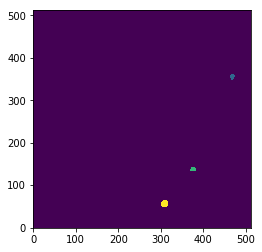

In [86]:
plt.imshow(mask, origin='bottom')

In [36]:
r = critical_points.classify_critical_points_hexgrid(lav)